# IMPORTING LIB

In [30]:
import os
import numpy as np
import pyroomacoustics as pra
from scipy.io import wavfile
from sklearn.decomposition import FastICA
import matplotlib.pyplot as plt
from IPython.display import Audio

# SOURCE GENERATION

In [29]:
# Load the audio file
fs, voice1 = wavfile.read("samples/voice1.wav")

# Normalize the audio signal
voice1 = voice1 / abs(voice1).max()

# Listen to the normalized audio
Audio(voice1, rate=fs)

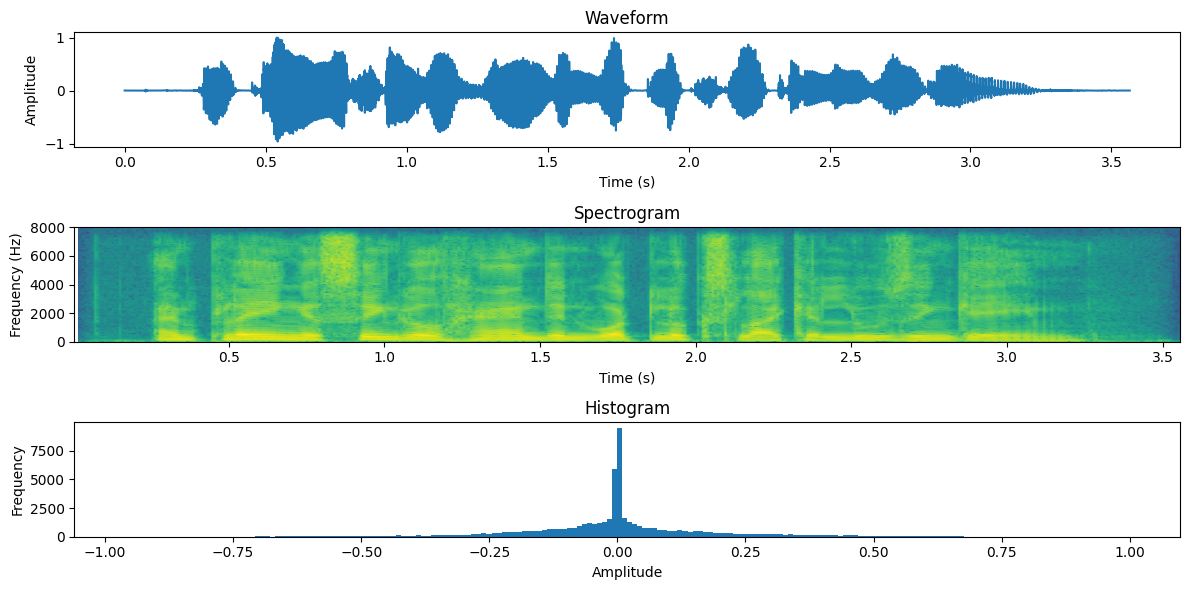

In [11]:
# Plot the waveform
plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(np.arange(len(voice1)) / fs, voice1)
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Plot the spectrogram
plt.subplot(3, 1, 2)
plt.specgram(voice1, Fs=fs, cmap='viridis')
plt.title('Spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')

# Plot the histogram
plt.subplot(3, 1, 3)
plt.hist(voice1, bins=200)
plt.title('Histogram')
plt.xlabel('Amplitude')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [5]:
# Generate colored noise with the same length as the audio file
noise = np.random.randn(len(voice1))

# Normalize the audio signal
noise = noise / abs(voice1).max()

# Listen to the colored noise
Audio(noise, rate=fs)

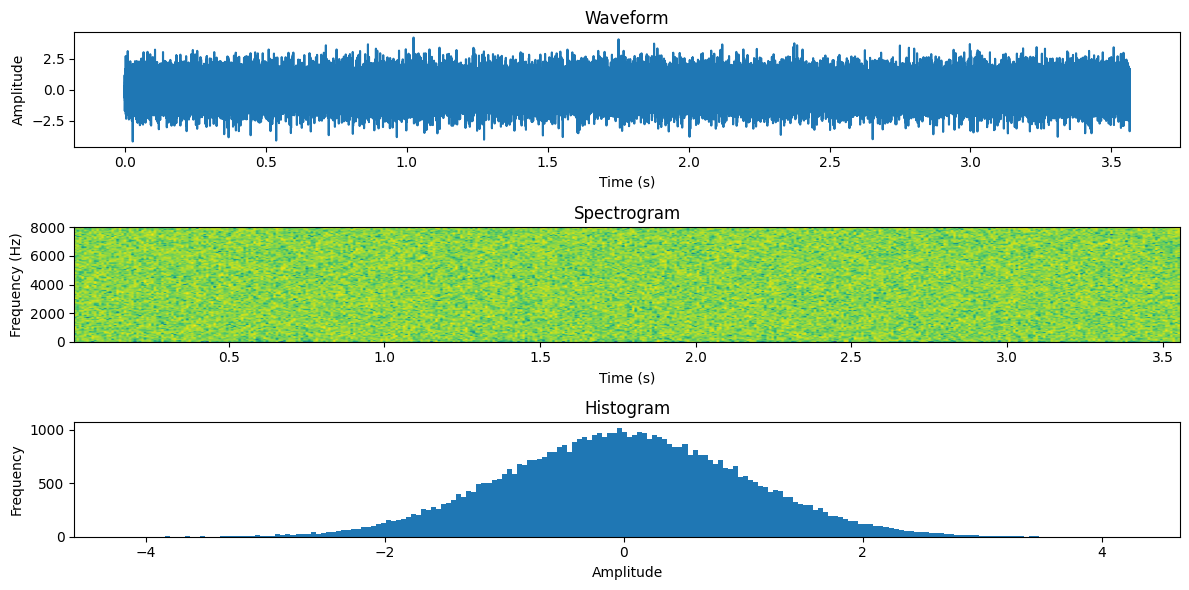

In [12]:
# Plot the waveform
plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(np.arange(len(noise)) / fs, noise)
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Plot the spectrogram
plt.subplot(3, 1, 2)
plt.specgram(noise, Fs=fs, cmap='viridis')
plt.title('Spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')

# Plot the histogram
plt.subplot(3, 1, 3)
plt.hist(noise, bins=200)
plt.title('Histogram')
plt.xlabel('Amplitude')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# ROOM CREATION

Text(0.5, 0, 'Z')

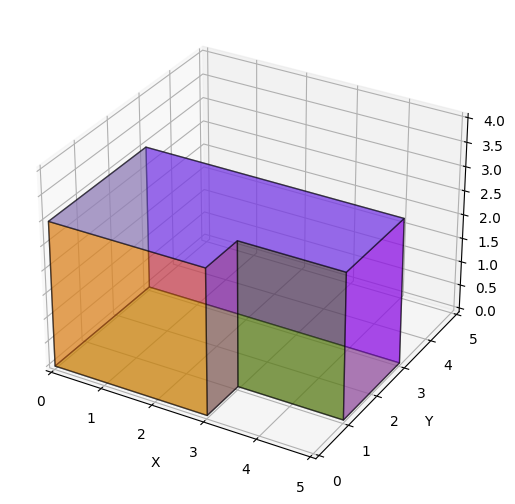

In [23]:
# Define the corners of a 2D room as an array of (x, y) coordinates
corners = np.array([[0,0], [0,3], [5,3], [5,1], [3,1], [3,0]]).T  # [x,y]

# Create a 2D room object from the given corners
# max_order: Maximum reflection order for ray tracing
# materials: Defines the acoustic properties of the walls (absorption coefficient, reflection coefficient)
room = pra.Room.from_corners(corners, max_order=3, materials=pra.Material(0.2, 0.15), ray_tracing=True, air_absorption=True, fs=16000)

# Set the parameters for ray tracing
# receiver_radius: Radius of the receiver for computing the visibility polygon
# n_rays: Number of rays to use for ray tracing
# energy_thres: Threshold energy for ray termination
room.set_ray_tracing(receiver_radius=0.5, n_rays=10000, energy_thres=1e-5)

# Extrude the 2D room to create a 3D room with a specified height
# materials: Defines the acoustic properties of the walls in 3D (absorption coefficient, reflection coefficient)
room.extrude(3., materials=pra.Material(0.2, 0.15))

# Plot the room
fig, ax = room.plot()
ax.set_xlim([0, 5])  # Set x-axis limits
ax.set_ylim([0, 5])  # Set y-axis limits
ax.set_zlim([0, 4])  # Set z-axis limits
ax.set_xlabel('X')  # Label for x-axis
ax.set_ylabel('Y')  # Label for y-axis
ax.set_zlabel('Z')  # Label for z-axis

Text(0.5, 0, 'Z')

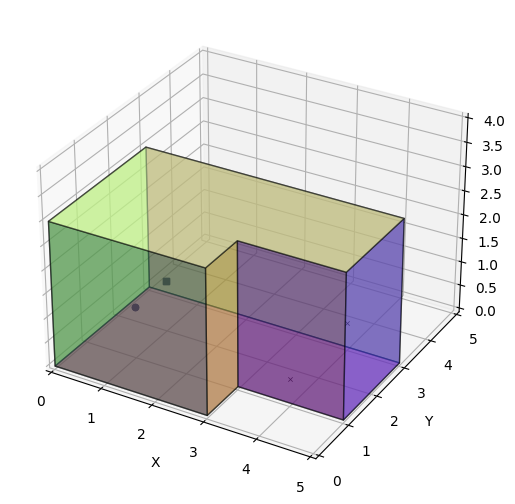

In [24]:
# Define the location of sources within the room
source1_loc = [1., 1., 1.]
source2_loc = [1., 2., 1.]

# Add source 1 to the room with a specified signal (voice1)
room.add_source(source1_loc, signal=voice1)

# Add source 2 to the room with a specified signal (noise)
room.add_source(source2_loc, signal=noise)

# Define the positions of two microphones in 3D space
# Ensure each microphone position is specified in 3D (x, y, z) coordinates
mic_positions = np.array([[4., 4.], [1., 3.], [0.5,  0.5]])

# Add the microphone array to the room
room.add_microphone_array(pra.MicrophoneArray(mic_positions, fs))

# Plot the room with sources and microphone array
fig, ax = room.plot()

# Set limits for the plot's x, y, and z axes
ax.set_xlim([0, 5])  # Set x-axis limits
ax.set_ylim([0, 5])  # Set y-axis limits
ax.set_zlim([0, 4])  # Set z-axis limits

# Label the axes for clarity
ax.set_xlabel('X')  # Label for x-axis
ax.set_ylabel('Y')  # Label for y-axis
ax.set_zlabel('Z')  # Label for z-axis


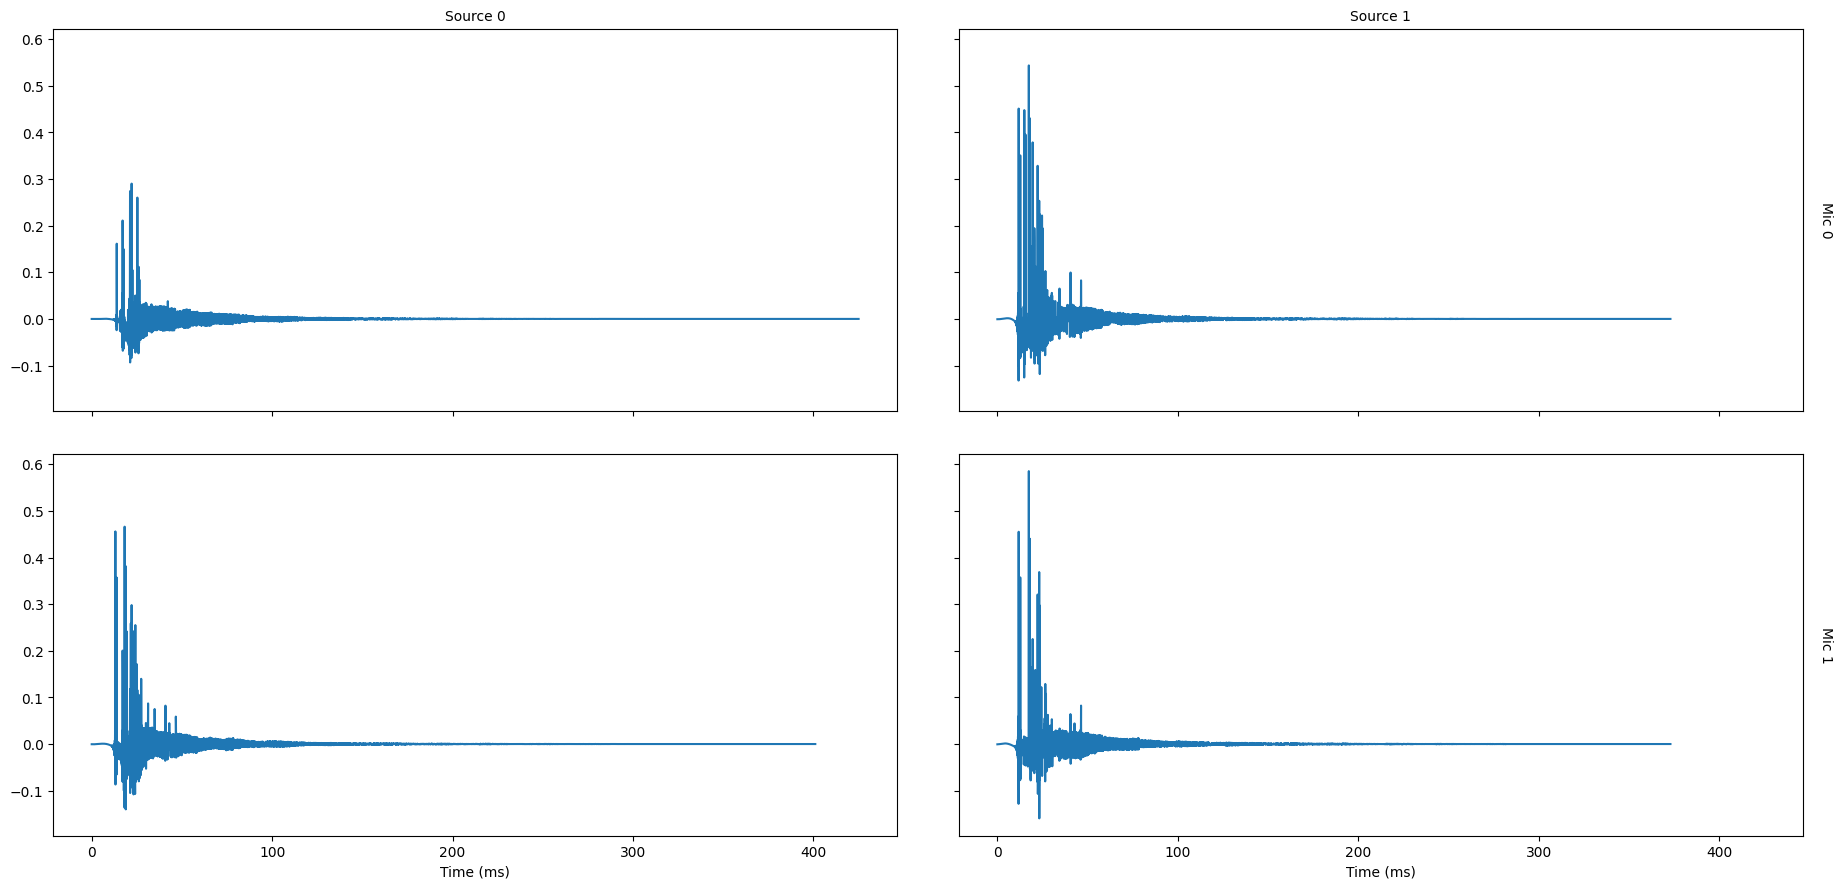

In [25]:
# Plot the room impulse response (RIR)
room.plot_rir()

# Get the current figure
fig = plt.gcf()

# Set the size of the figure for better visualization
fig.set_size_inches(20, 10)

In [38]:
room.simulate()

# INSPECT RECORDINGS

In [42]:
# Simulate propagation to first mic and play audio
print("Simulated propagation to first mic:")
display(Audio(room.mic_array.signals[0, :], rate=fs))

# Simulate propagation to second mic and play audio
print("Simulated propagation to second mic:")
display(Audio(room.mic_array.signals[1, :], rate=fs))

Simulated propagation to first mic:


Simulated propagation to second mic:


/Users/Pietrusco/OneDrive - Politecnico di Milano/Music Engineering/Information Theory/ICA-Information-Theory/ICAenv/lib/python3.8/site-packages/matplotlib/axes/_axes.py:7774: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


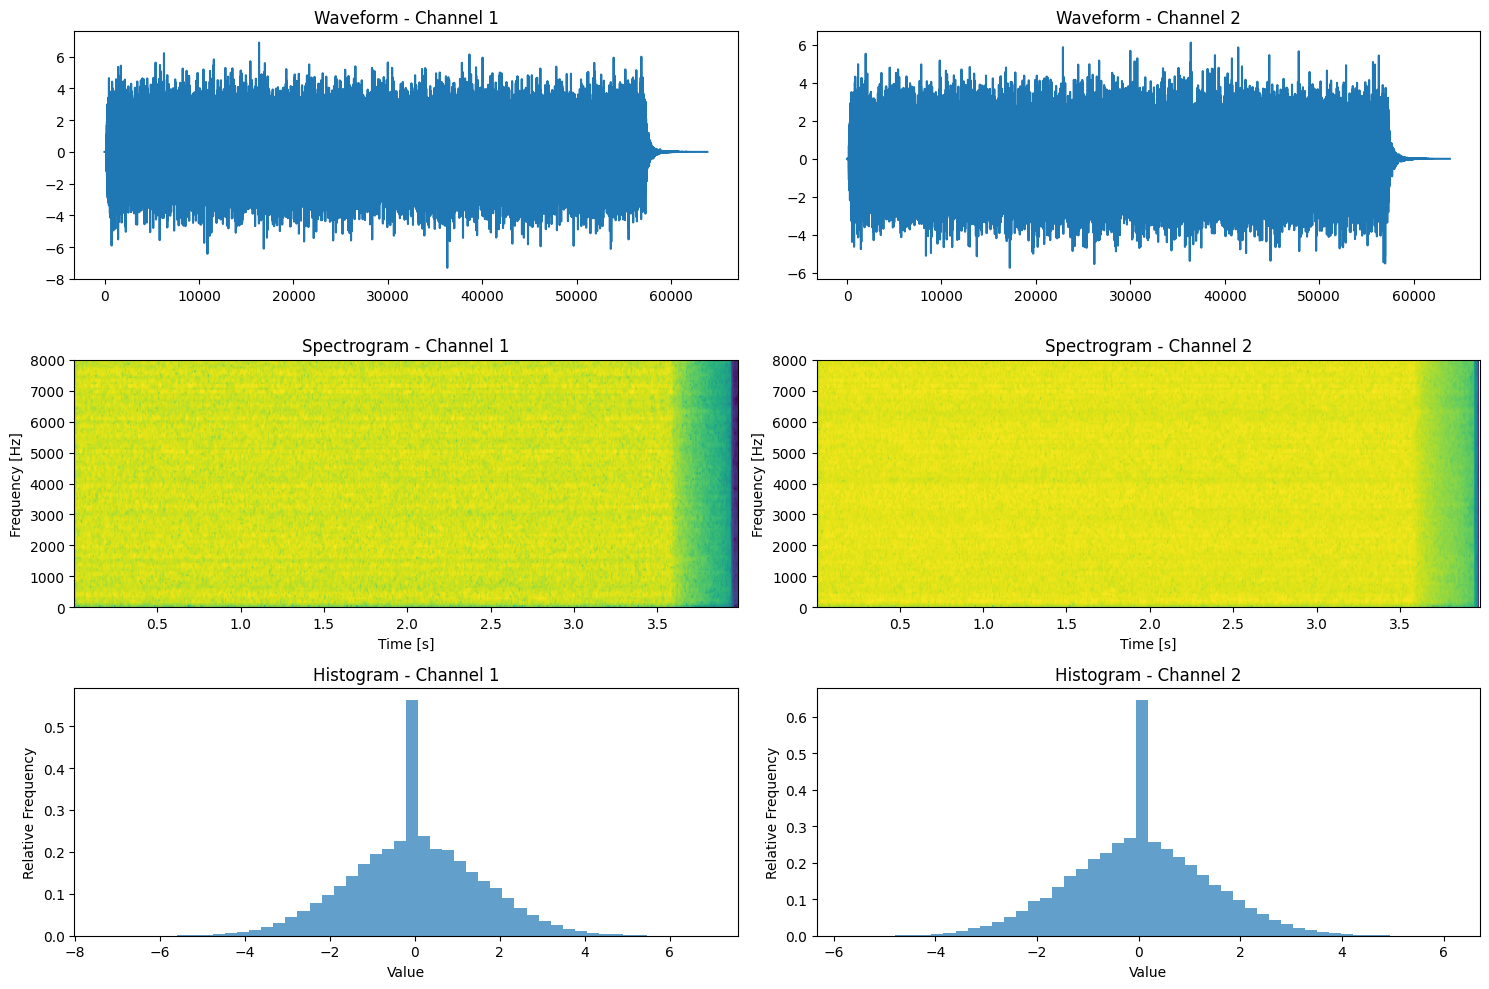

In [27]:
# Create subplots
fig, axs = plt.subplots(3, 2, figsize=(15, 10))

# Plot waveforms
for i in range(room.mic_array.signals.shape[0]):
    axs[0, i].plot(room.mic_array.signals[i])
    axs[0, i].set_title(f'Waveform - Channel {i+1}')

# Plot spectrograms
for i in range(room.mic_array.signals.shape[0]):
    axs[1, i].specgram(room.mic_array.signals[i], Fs=fs)
    axs[1, i].set_ylabel('Frequency [Hz]')
    axs[1, i].set_xlabel('Time [s]')
    axs[1, i].set_title(f'Spectrogram - Channel {i+1}')

# Plot histograms
for i in range(room.mic_array.signals.shape[0]):
    axs[2, i].hist(room.mic_array.signals[i], bins=50, density=True, alpha=0.7)
    axs[2, i].set_xlabel('Value')
    axs[2, i].set_ylabel('Relative Frequency')
    axs[2, i].set_title(f'Histogram - Channel {i+1}')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

# FastICA 

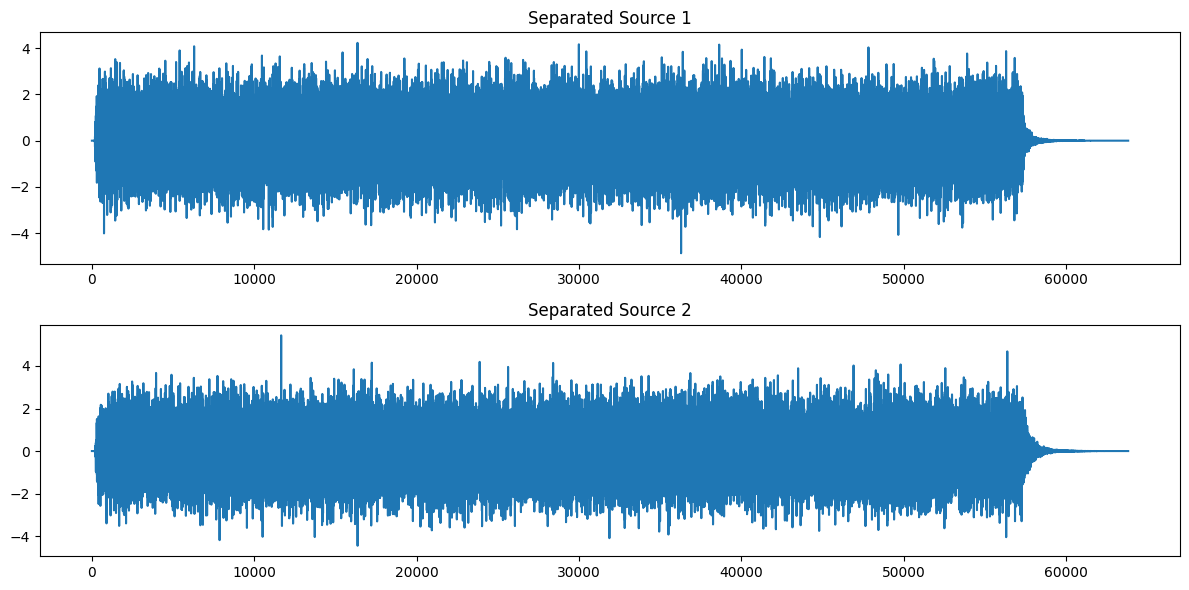

In [46]:

# Transpose the signals matrix to have the shape (num_samples, num_channels)
signals = room.mic_array.signals.T

# Apply FastICA to separate the sources
ica = FastICA(n_components=2)
sources = (ica.fit_transform(signals)).T

# Plot the separated sources
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(sources[0, :])
plt.title('Separated Source 1')

plt.subplot(2, 1, 2)
plt.plot(sources[1, :])
plt.title('Separated Source 2')

plt.tight_layout()
plt.show()


In [47]:
# Simulate propagation to first mic and play audio
print("Simulated propagation to first mic:")
display(Audio(sources[0, :], rate=fs))

# Simulate propagation to second mic and play audio
print("Simulated propagation to second mic:")
display(Audio(sources[1, :], rate=fs))

Simulated propagation to first mic:


Simulated propagation to second mic:


# Nuova sezione